In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os
import netCDF4 as nc
from torch import nn, optim
from torch.utils.data import DataLoader,TensorDataset
import torch.utils.data as data
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.colors as colors
import csv

In [11]:
def load_nc_data(file_path):
    """Loads NetCDF data from the given file path."""
    dataset = nc.Dataset(file_path, mode='r')
    lon = dataset.variables["longitude"][:].tolist()
    lat = dataset.variables["latitude"][:].tolist()
    return dataset.variables['z'][:], lon, lat

def normalize_per_channel(data):
    """
    Normalization per channel for data with shape (T, C, H, W).
    Each channel is normalized across all frames and spatial dimensions to have mean 0 and standard deviation 1.
    """
    data = data.astype(np.float32)

    # Compute mean and std for each channel across T, H, and W dimensions.
    mean = data.mean(axis=(0, 2, 3), keepdims=True)
    std = data.std(axis=(0, 2, 3), keepdims=True)
    normalized_data = (data - mean) / (std + 1e-8)
    return normalized_data

def combine_data(files):
    """
    Loads and combines data from multiple NetCDF files into one torch tensor.
    The data from each file is normalized per channel and concatenated along the time dimension.
    Also, the latitude and longitude values are stored in lists.
    """
    all_data = []
    lon_list = []
    lat_list = []
    for file in files:
        data, lon, lat = load_nc_data(file)
        all_data.append(data)
        
        # Append the lat/lon values to the lists
        lon_list = lon
        lat_list = lat
    
    combined_data = np.concatenate(all_data, axis=0)
    combined_data = normalize_per_channel(combined_data) #Normalize data when all the data is combined
    return torch.tensor(combined_data, dtype=torch.float32), lon_list, lat_list


def add_sparsity(data, sparsity=20):
    """
    Adds sparsity by setting k% of random spatial points to zero for each frame.
    Also returns a mask indicating which points were set to zero.
    
    Args:
        data (torch.Tensor): Tensor of shape (T, C, H, W).
        sparsity (int): Percentage of spatial points to zero out.
        
    Returns:
        torch.Tensor: The sparsified tensor with extra channel for mask
    """
    T, C, H, W = data.shape
    k = int(H * W * sparsity / 100)
    data_sparse = data.clone()
    mask = torch.ones((T, 1, H, W), dtype=data.dtype, device=data.device)  # Initialize shared mask with ones

    for t in range(T):
        indices = torch.randperm(H * W)[:k]

        for c in range(C):
            data_sparse[t, c].view(-1)[indices] = 0
        
        mask[t,0].view(-1)[indices] = 0  # Set mask to 0 where data is sparsified
    
    data_sparse_with_mask = torch.cat([data_sparse, mask], dim=1)  # Concatenate data and mask along channel dimension
    return data_sparse_with_mask

class ReconstructionDataset(data.Dataset):
    """
    Custom Dataset that provides a tuple (sparse_data, clean_data) for each sample.
    This allows the neural network to learn to reconstruct the clean data from the sparse version.
    """
    def __init__(self, files, sparsity=20, apply_sparsity=True):
        # Load and combine the clean data along with latitude and longitude values.
        self.clean_data, self.lon, self.lat = combine_data(files)
        
        # Create a sparse version if requested.
        if apply_sparsity:
            self.sparse_data = add_sparsity(self.clean_data, sparsity)
        else:
            self.sparse_data = self.clean_data  # No sparsity applied (e.g., for testing)
        
    def __len__(self):
        return self.clean_data.shape[0]
    
    def __getitem__(self, idx):
        # Return a tuple: (sparse input, clean target)
        return self.sparse_data[idx], self.clean_data[idx]

# Data preparation
def make_dataloader(k,batch_size=16):
    dir_path = os.path.abspath(os.path.join(os.getcwd(), "../data/"))
    print(os.listdir(dir_path))
    files = [f for f in os.listdir(dir_path) if f.endswith('.nc')]
    
    # Separate train and test files based on your criteria
    train_files = [os.path.join(dir_path, file) for file in files if file != "z1985.nc"]
    test_files = [os.path.join(dir_path, "z1985.nc")]
    
    # Create datasets: for training, apply sparsity; for testing, you might want clean data or a controlled sparsity level.
    train_dataset = ReconstructionDataset(train_files, sparsity=k, apply_sparsity=True)
    test_dataset = ReconstructionDataset(test_files, sparsity=k, apply_sparsity=True)
    
    # Create DataLoaders for training and testing
    train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Finished loading data")

    return train_dataloader,test_dataloader,train_dataset, test_dataset

train_dataloader,test_dataloader,train_dataset,test_dataset = make_dataloader(30,16)
# Print information about dataset
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Shape of clean data: {train_dataset.clean_data.shape}")
print(f"Shape of sparse data: {train_dataset.sparse_data.shape}")



['z1979.nc', 'z1980.nc', 'z1981.nc', 'z1983.nc', 'z1985.nc']
Finished loading data
Number of training samples: 5844
Number of testing samples: 1460
Shape of clean data: torch.Size([5844, 2, 91, 180])
Shape of sparse data: torch.Size([5844, 3, 91, 180])


In [12]:
def visualize(model, sparse_data, clean_data, num_samples=1):
    model.eval()
    with torch.no_grad():
        # Select a subset of the data for visualization
        x_sparse = sparse_data[:num_samples]
        x_clean = clean_data[:num_samples]
        
        # Generate reconstructions from sparse data
        recon_batch, _, _ = model(x_sparse)
        
        # Determine the colorbar limits based on the clean data and reconstruction
        # Only consider the data channels (first two channels)
        vmin = min(
            x_clean[:, :2].min().item(), 
            x_sparse[:, :2].min().item(),
            recon_batch[:, :2].min().item()
        )
        vmax = max(
            x_clean[:, :2].max().item(), 
            x_sparse[:, :2].min().item(),
            recon_batch[:, :2].max().item()
        )
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        
        # Set up the figure and axes for plotting - 7 columns as requested
        fig, axs = plt.subplots(num_samples, 7, figsize=(21, 3 * num_samples))
        
        # Add a title to the figure
        fig.suptitle('VAE Reconstruction Comparison', fontsize=16)
        
        # Function to add colorbar
        def add_colorbar(c, ax):
            cbar = fig.colorbar(c, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=8)
        
        # Column titles
        column_titles = [
            "Mask", 
            "Clean Input (ch0)", "Sparse Input (ch0)", "Reconstructed (ch0)",
            "Clean Input (ch1)", "Sparse Input (ch1)", "Reconstructed (ch1)"
        ]

        contour_levels = 20
        
        # Plotting each sample
        for i in range(num_samples):
            # If only one sample, make sure we can index with [i, j]
            if num_samples == 1:
                axs = axs.reshape(1, -1)
            
            # Plot mask first
            c = axs[i, 0].contourf(x_sparse[i, 2].cpu(), levels=contour_levels, cmap='binary')
            axs[i, 0].set_title(column_titles[0])
            add_colorbar(c, axs[i, 0])
            
            # Channel 0 plots
            # Clean input (channel 0)
            c = axs[i, 1].contourf(x_clean[i, 0].cpu(), levels=contour_levels, cmap='viridis', norm=norm)
            axs[i, 1].set_title(column_titles[1])
            add_colorbar(c, axs[i, 1])
            
            # Sparse input (channel 0)
            c = axs[i, 2].contourf(x_sparse[i, 0].cpu(), levels=contour_levels, cmap='viridis', norm=norm)
            axs[i, 2].set_title(column_titles[2])
            add_colorbar(c, axs[i, 2])
            
            # Reconstructed input (channel 0)
            c = axs[i, 3].contourf(recon_batch[i, 0].cpu(), levels=contour_levels, cmap='viridis', norm=norm)
            axs[i, 3].set_title(column_titles[3])
            add_colorbar(c, axs[i, 3])
            
            # Channel 1 plots
            # Clean input (channel 1)
            c = axs[i, 4].contourf(x_clean[i, 1].cpu(), levels=contour_levels, cmap='viridis', norm=norm)
            axs[i, 4].set_title(column_titles[4])
            add_colorbar(c, axs[i, 4])
            
            # Sparse input (channel 1)
            c = axs[i, 5].contourf(x_sparse[i, 1].cpu(), levels=contour_levels, cmap='viridis', norm=norm)
            axs[i, 5].set_title(column_titles[5])
            add_colorbar(c, axs[i, 5])
            
            # Reconstructed input (channel 1)
            c = axs[i, 6].contourf(recon_batch[i, 1].cpu(), levels=contour_levels, cmap='viridis', norm=norm)
            axs[i, 6].set_title(column_titles[6])
            add_colorbar(c, axs[i, 6])
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
        plt.show()

['z1979.nc', 'z1980.nc', 'z1981.nc', 'z1983.nc', 'z1985.nc']
Finished loading data
====> Epoch: 1 Average loss: 21954.5011
====> Test set loss: 21650.2433


KeyboardInterrupt: 

In [21]:
class ImprovedVAE(torch.nn.Module):
    def __init__(self, latent_dim=512, device="cuda"):
        super(ImprovedVAE, self).__init__()
        self.device = device
        self.latent_dim = latent_dim
        
        # Calculate the encoded dimensions for input size (batch, 3, 91, 180)
        # With the improved architecture, we'll use more layers with smaller strides
        self.encoder_output_shape = (512, 5, 11)  # Changed from (512, 6, 12)
        self.flattened_dim = 512 * 5 * 11  # Changed from 512 * 6 * 12
        
        # Improved Encoder - more layers, residual connections, batch normalization
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # (batch, 64, 91, 180)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (batch, 128, 46, 90)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (batch, 256, 46, 90)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1),  # (batch, 256, 23, 45)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # (batch, 512, 23, 45)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # (batch, 512, 12, 23)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # (batch, 512, 6, 12)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.flatten = nn.Flatten()
        
        # Latent space mapping
        self.fc_mu = nn.Linear(self.flattened_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_dim, self.latent_dim)
        self.decoder_input = nn.Linear(self.latent_dim, self.flattened_dim)
        
        # Improved Decoder with residual connections and more layers
        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),  # (batch, 512, 12, 24)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),  # (batch, 512, 24, 48)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1),  # (batch, 256, 24, 48)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, output_padding=1),  # (batch, 256, 48, 96)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),  # (batch, 128, 48, 96)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=(1,0)),  # (batch, 64, 96, 192)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),  # (batch, 32, 96, 192)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),  # (batch, 3, 96, 192)
            nn.Upsample(size=(91, 180), mode='bilinear', align_corners=False),  # Ensure exact output size
        )
        
    def reparameterize(self, mu, logvar):
        # Improved reparameterization with KL annealing
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, *self.encoder_output_shape)
        x = self.decoder_deconv(z)
        return x
    
    def forward(self, x):
        # Encoding
        x = self.encoder_conv(x)
        x = self.flatten(x)
        
        # Latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        
        # Decoding
        x = self.decoder_input(z)
        x = x.view(-1, 512, 5, 11)  # Changed from x.view(-1, 512, 6, 12)
        x = self.decoder_deconv(x)
        
        return x, mu, logvar
        
    def loss_function(self, recon_x, x, mu, logvar):

        # KL Divergence loss with a beta parameter for better control
        beta = 0.5  # Adjust beta to balance reconstruction and KL divergence
        # Only compare the first two channels of x with each other
        MSE_loss = F.mse_loss(recon_x[:,:2], x[:, :2], reduction='sum')
        
        # KL Divergence loss with a beta parameter for better control
        KLD_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        return MSE_loss + beta * KLD_loss,MSE_loss,KLD_loss*beta
        
    def sample(self, num_samples=1):
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim).to(self.device)
            x = self.decode(z)
            return x
    
    def generate(self, z):
        with torch.no_grad():
            x = self.decode(z)
            return x
    
    def reconstruct(self, x):
        with torch.no_grad():
            mu, logvar = self.encode(x)
            z = self.reparameterize(mu, logvar)
            x_recon = self.decode(z)
            return x_recon
    
    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()

# Improved training function with annealing and early stopping
def train_improved(model, train_loader, optimizer, scheduler, epoch, device, max_epochs=10):
    model.train()
    train_loss = 0
    mse_loss_total = 0
    kl_loss_total = 0
    
    for batch_idx, (data_sparse, data_clean) in enumerate(train_loader):
        data_sparse = data_sparse.to(device)
        data_clean = data_clean.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_sparse)
        
        loss, mse_loss, kl_loss = model.loss_function(recon_batch, data_clean, mu, logvar)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10, norm_type=2.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        mse_loss_total += mse_loss.item()
        kl_loss_total += kl_loss.item()
        
        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data_sparse)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    avg_loss = train_loss / len(train_loader)
    avg_mse = mse_loss_total / len(train_loader)
    avg_kl = kl_loss_total / len(train_loader)

    # Step the learning rate scheduler
    scheduler.step(avg_loss)
    
    print('====> Epoch: {} Average loss: {:.4f}, MSE: {:.4f}, KL: {:.4f}'.format(
        epoch, avg_loss, avg_mse, avg_kl))
    
    return avg_loss, avg_mse, avg_kl

def test(model, test_loader, epoch, device):
    model.eval()
    test_loss_total = 0
    with torch.no_grad():
        for i, (data_sparse, data_clean) in enumerate(test_loader):
            data_sparse = data_sparse.to(device)
            data_clean = data_clean.to(device)
            
            recon_batch, mu, logvar = model(data_sparse)
            
            # Compare reconstruction with clean data
            test_loss,_,_ = model.loss_function(recon_batch, data_clean, mu, logvar)
            test_loss_total += test_loss
    
    test_loss_total /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss_total))
    return test_loss_total

# Improved main function with better training process
def main_improved():
    train_mode = False  # Set to True to train, False to load a model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for k in [30,60,90]:
        # Create dataloaders with increased batch size for better stability
        train_dataloader, test_dataloader, train_dataset, test_dataset = make_dataloader(k=k, batch_size=32)
        
        # Model with increased latent dimension
        model = ImprovedVAE(latent_dim=512).to(device)
        
        if train_mode:
            # Use Adam optimizer with lower learning rate
            optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
            
            # Learning rate scheduler for better convergence
            scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=5, T_mult=2, eta_min=1e-6, last_epoch=-1
    )
            
            num_epochs = 20
            best_loss = float('inf')
            patience = 5
            patience_counter = 0
            
            # Lists to track training progress
            train_losses, mse_losses, kl_losses, test_losses = [], [], [], []


            with open(f'losses_{k}.csv', 'w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Epoch', 'Total Loss', 'MSE Loss', 'KL Loss', 'Test Loss'])
                            
                for epoch in range(1, num_epochs + 1):
                    # Add warmup phase in training loop:
                    if epoch <= 5:  # Warmup first 5 epochs
                        lr = 3e-5 * (epoch/5)
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                            
                    # Train
                    avg_loss, avg_mse, avg_kl = train_improved(model, train_dataloader, optimizer, scheduler, epoch, device, num_epochs)

                    # Track losses
                    train_losses.append(avg_loss)
                    mse_losses.append(avg_mse)
                    kl_losses.append(avg_kl)
                    
                    # Test
                    test_loss = test(model, test_dataloader, epoch, device)
    
                    test_losses.append(test_loss)

                    writer.writerow([epoch, avg_loss, avg_mse, avg_kl, test_loss])
                    
                    # Early stopping check
                    if test_loss < best_loss:
                        best_loss = test_loss
                        patience_counter = 0
                        # Save the best model
                        model.save_model(f"best_model_{k}.pth")
                        print(f"New best model saved with loss: {best_loss:.4f}")
                    else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epochs")
                        
                        if patience_counter >= patience:
                            print(f"Early stopping after {epoch} epochs")
                            break
                    
                    # Visualize reconstructions during training
                    if epoch % 5 == 0 or epoch == num_epochs:
                        # Get a batch of data for visualization
                        sparse_data, clean_data = next(iter(test_dataloader))
                        sparse_data = sparse_data.to(device)
                        clean_data = clean_data.to(device)
                        
                        visualize(model, sparse_data, clean_data, num_samples=2)
                        
                        # Plot training progress
                        plt.figure(figsize=(12, 5))
                        plt.subplot(1, 2, 1)
                        plt.plot(train_losses, label='Total Loss')
                        plt.plot(mse_losses, label='MSE Loss')
                        plt.title('Training Losses')
                        plt.xlabel('Epoch')
                        plt.ylabel('Loss')
                        plt.legend()
                        
                        plt.subplot(1, 2, 2)
                        plt.plot(kl_losses, label='KL Loss')
                        plt.title('KL Divergence Loss')
                        plt.xlabel('Epoch')
                        plt.ylabel('Loss')
                        plt.legend()
                        
                        plt.tight_layout()
                        plt.show()
                
            # Load the best model for evaluation
            model.load_model(f"best_model_{k}.pth")
            
        else:
            # Load a pre-trained model
            model.load_model(f"best_model_{k}.pth")
        
        # Final visualization
        sparse_data, clean_data = next(iter(test_dataloader))
        sparse_data = sparse_data.to(device)
        clean_data = clean_data.to(device)
        
        visualize(model, sparse_data, clean_data, num_samples=5)

#if __name__ == "__main__":
    #main_improved()

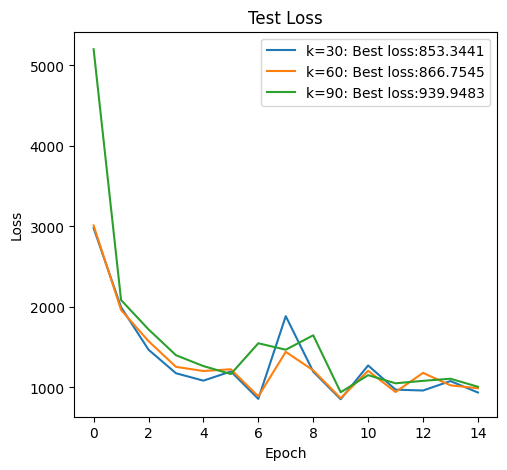

Best test loss for k=30: 853.3441
Best test loss for k=60: 866.7545
Best test loss for k=90: 939.9483


In [39]:
# Plot losses for k = [30, 60, 90]

# Load the losses from the CSV files
losses_30 = pd.read_csv('losses_30.csv')
losses_60 = pd.read_csv('losses_60.csv')
losses_90 = pd.read_csv('losses_90.csv')

# Plot the losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Extract the numeric value from the "Test Loss" column
losses_30['Test Loss'] = losses_30['Test Loss'].apply(lambda x: float(str(x).split('(')[1].split(',')[0]))
losses_60['Test Loss'] = losses_60['Test Loss'].apply(lambda x: float(str(x).split('(')[1].split(',')[0]))
losses_90['Test Loss'] = losses_90['Test Loss'].apply(lambda x: float(str(x).split('(')[1].split(',')[0]))
plt.plot(losses_30['Test Loss'], label=f'k=30: Best loss:{losses_30["Test Loss"].min():.4f}')
plt.plot(losses_60['Test Loss'], label=f'k=60: Best loss:{losses_60["Test Loss"].min():.4f}')
plt.plot(losses_90['Test Loss'], label=f'k=90: Best loss:{losses_90["Test Loss"].min():.4f}')
plt.title('Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

# Print the best test loss for each k
print(f"Best test loss for k=30: {losses_30['Test Loss'].min():.4f}")
print(f"Best test loss for k=60: {losses_60['Test Loss'].min():.4f}")
print(f"Best test loss for k=90: {losses_90['Test Loss'].min():.4f}")

['z1979.nc', 'z1980.nc', 'z1981.nc', 'z1983.nc', 'z1985.nc']
Finished loading data
['z1979.nc', 'z1980.nc', 'z1981.nc', 'z1983.nc', 'z1985.nc']
Finished loading data
['z1979.nc', 'z1980.nc', 'z1981.nc', 'z1983.nc', 'z1985.nc']
Finished loading data


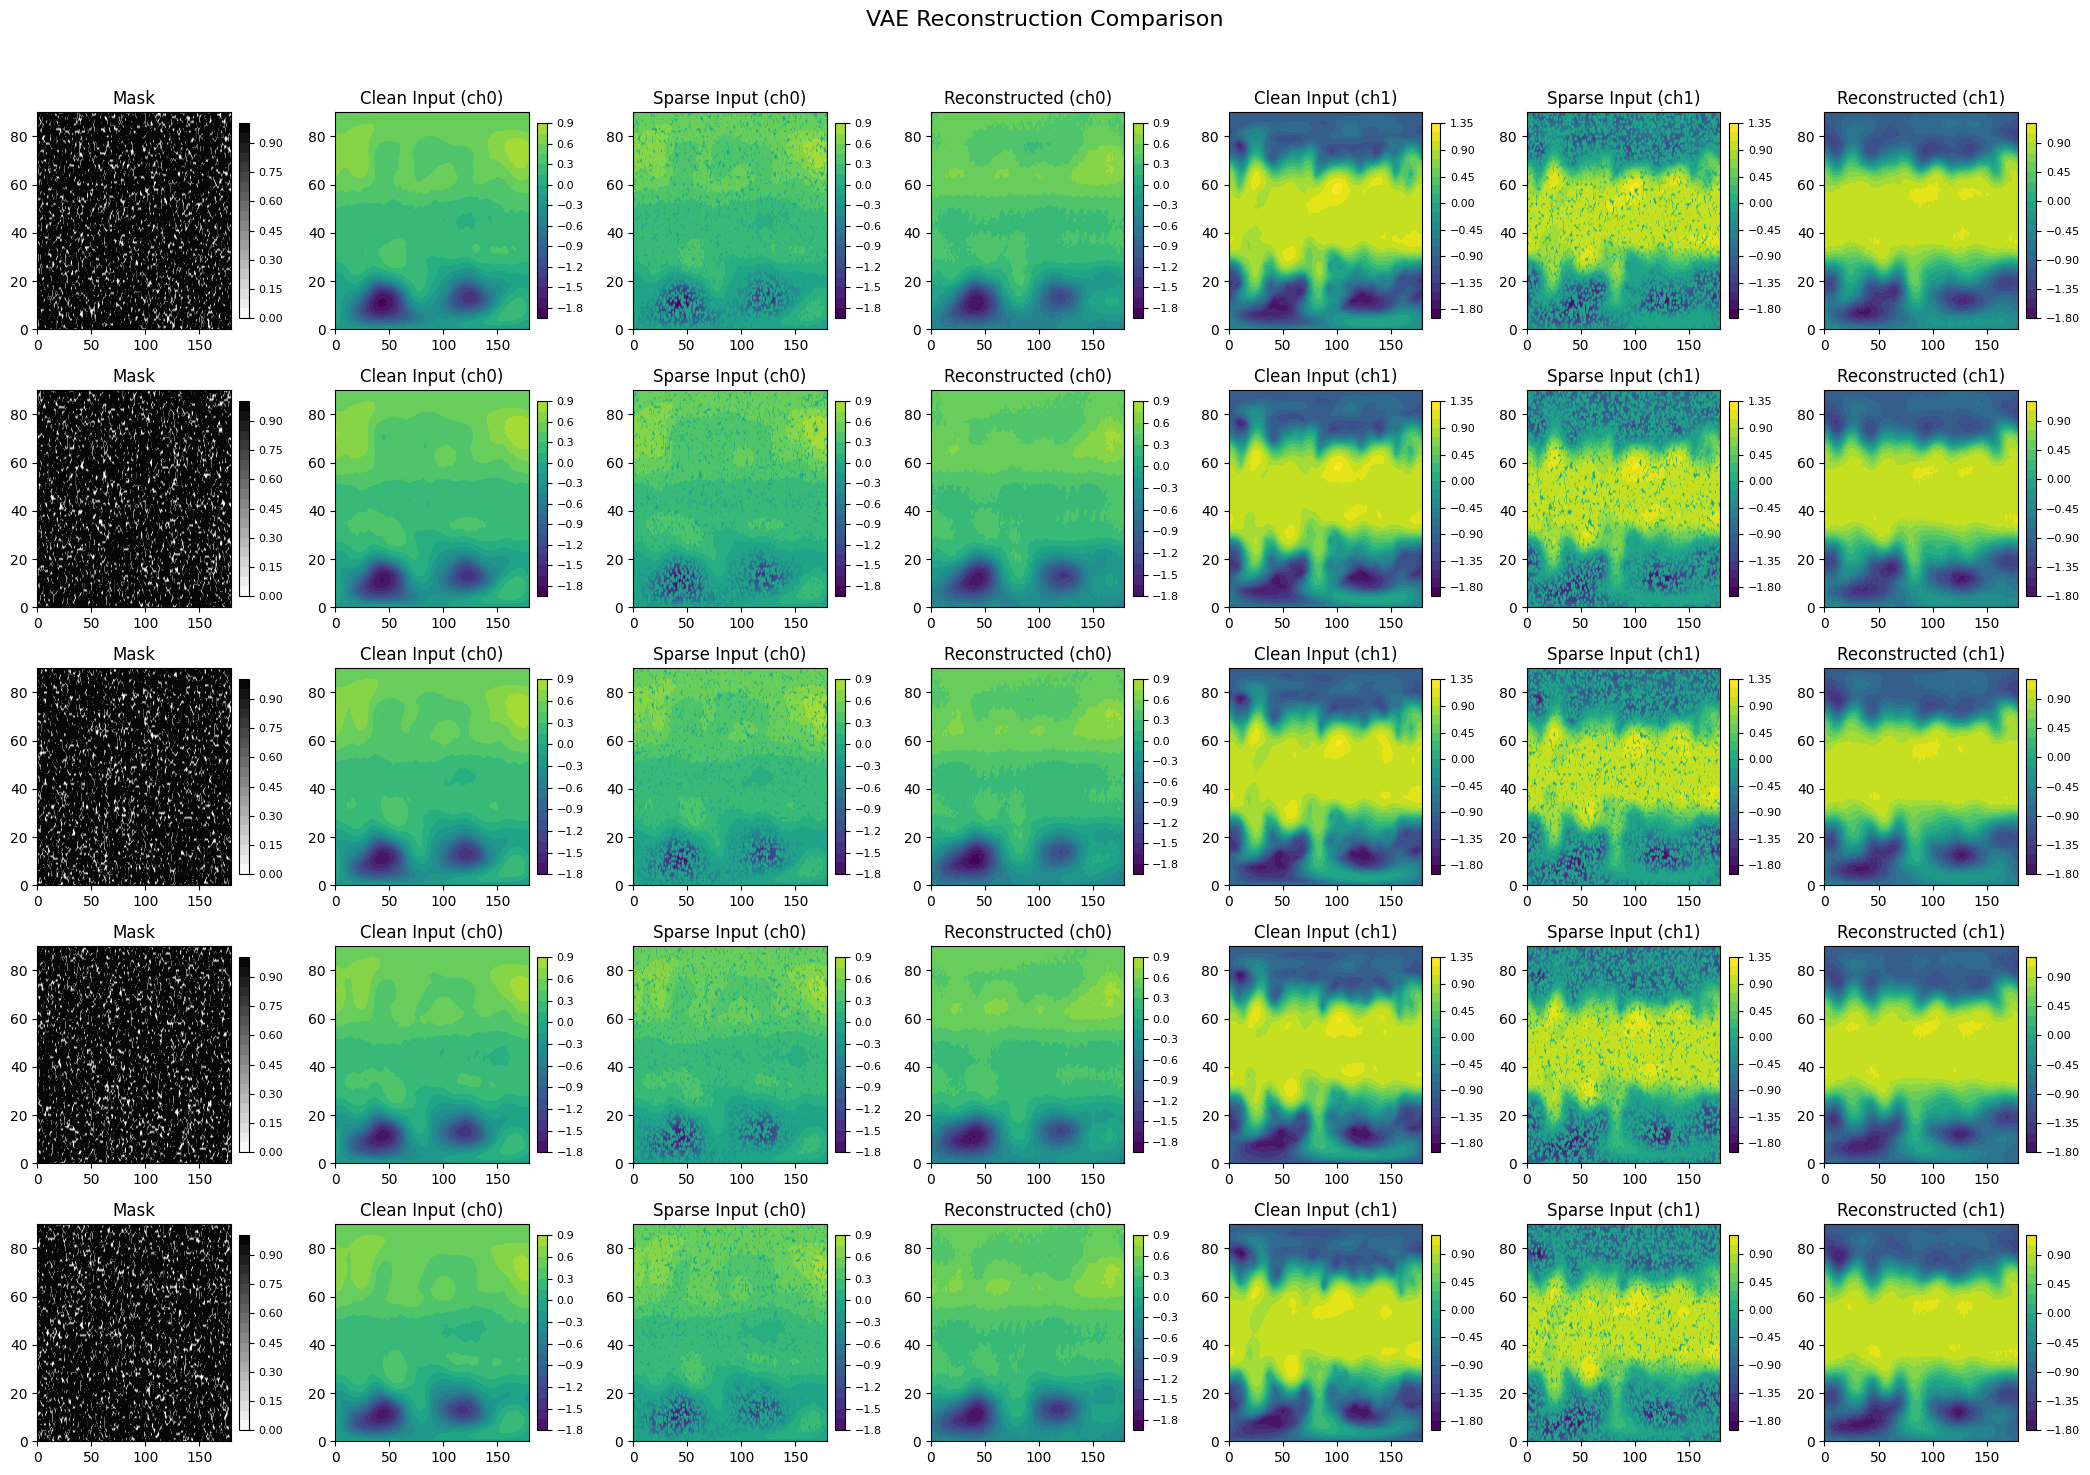

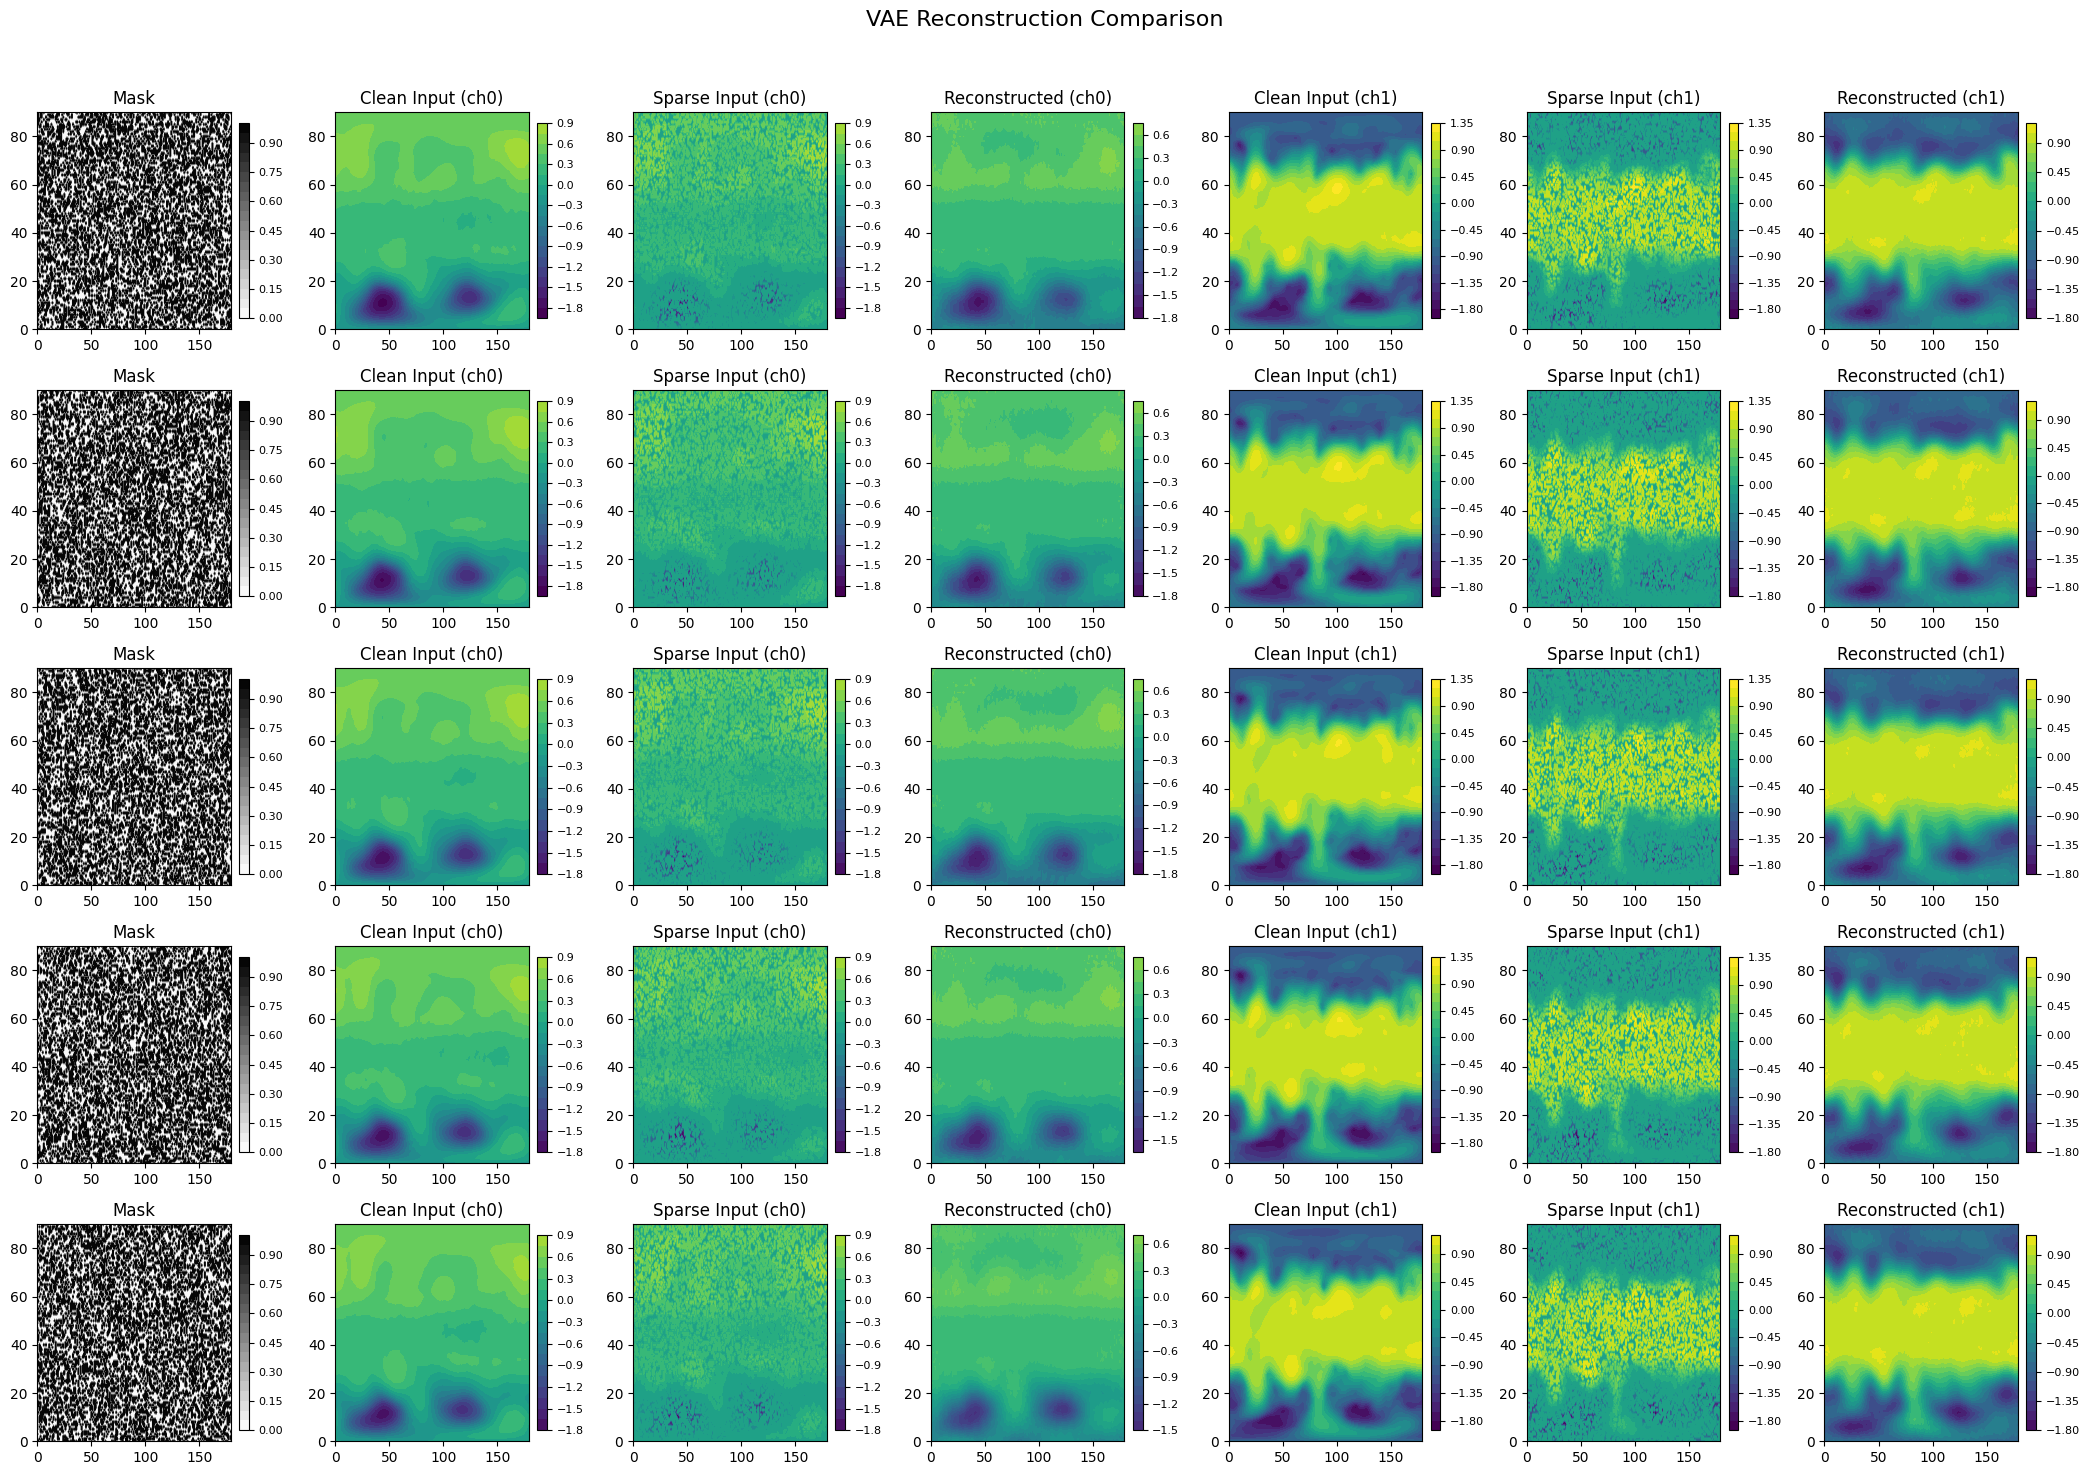

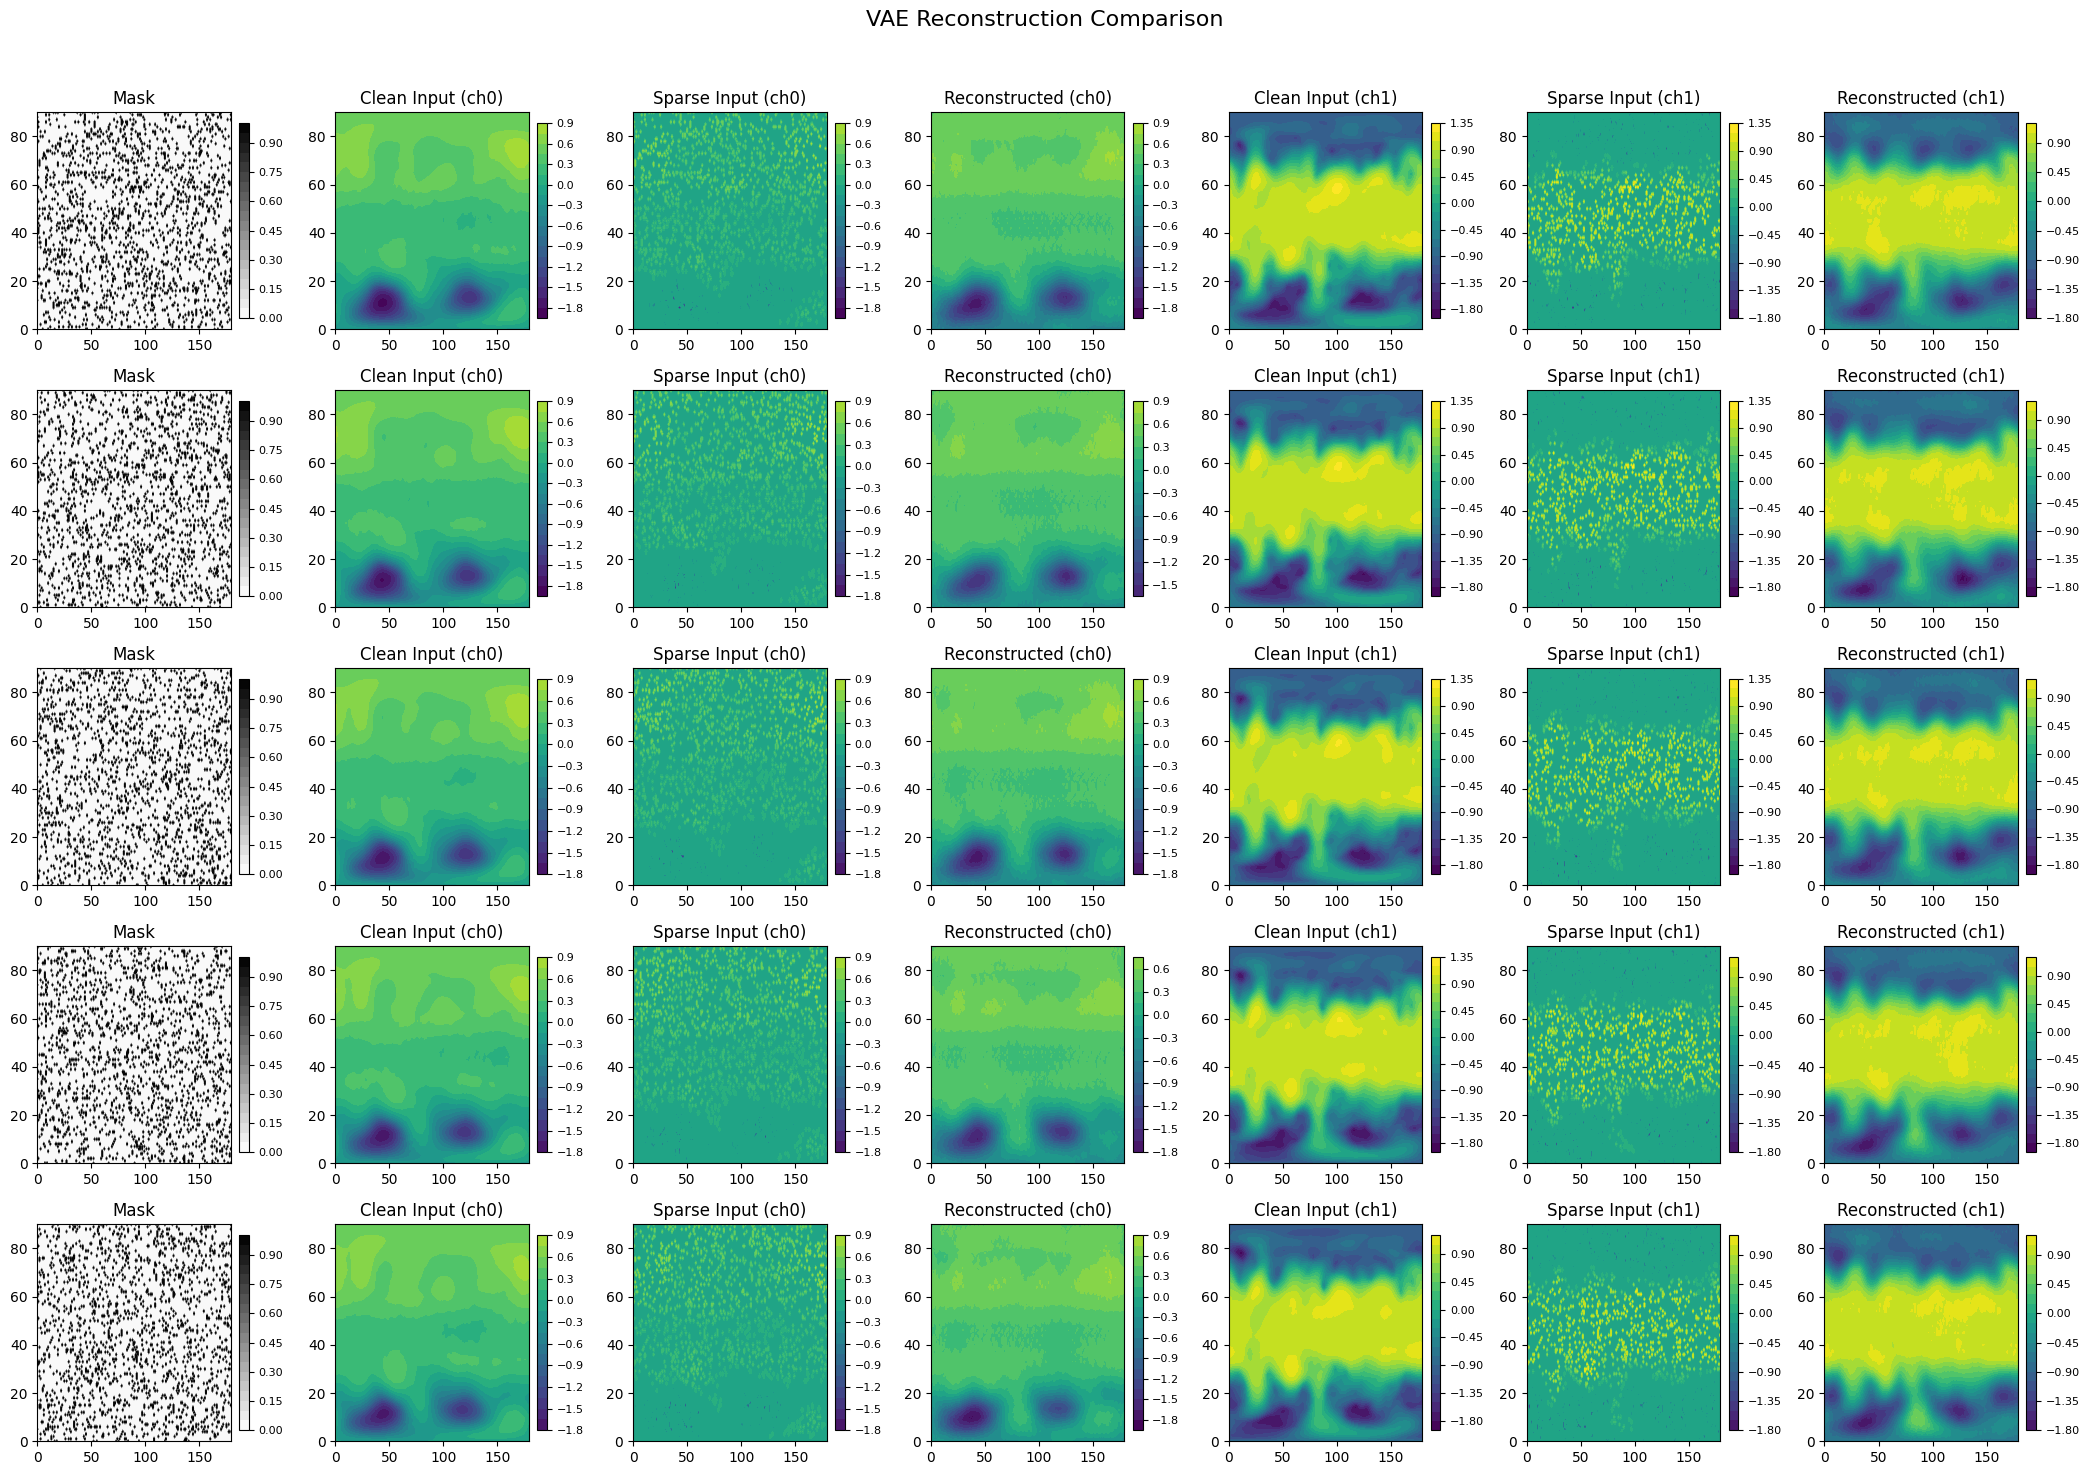

In [ ]:
import random

# Plot example reconstructions for k = [30, 60, 90]
# Load the best models
model_30 = ImprovedVAE(latent_dim=512)
model_30.load_state_dict(torch.load("best_model_30.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

model_60 = ImprovedVAE(latent_dim=512)
model_60.load_state_dict(torch.load("best_model_60.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

model_90 = ImprovedVAE(latent_dim=512)
model_90.load_state_dict(torch.load("best_model_90.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

# Create dataloaders for visualization
_, test_dataloader_30, _, _ = make_dataloader(30, batch_size=5)
_, test_dataloader_60, _, _ = make_dataloader(60, batch_size=5)
_, test_dataloader_90, _, _ = make_dataloader(90, batch_size=5)

# Visualize reconstructions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sparse_data_30, clean_data_30 = next(iter(test_dataloader_30))
sparse_data_30 = sparse_data_30.to(device)
clean_data_30 = clean_data_30.to(device)
visualize(model_30, sparse_data_30, clean_data_30, num_samples=5)

sparse_data_60, clean_data_60 = next(iter(test_dataloader_60))
sparse_data_60 = sparse_data_60.to(device)
clean_data_60 = clean_data_60.to(device)
visualize(model_60, sparse_data_60, clean_data_60, num_samples=5)

sparse_data_90, clean_data_90 = next(iter(test_dataloader_90))
sparse_data_90 = sparse_data_90.to(device)
clean_data_90 = clean_data_90.to(device)
visualize(model_90, sparse_data_90, clean_data_90, num_samples=5)




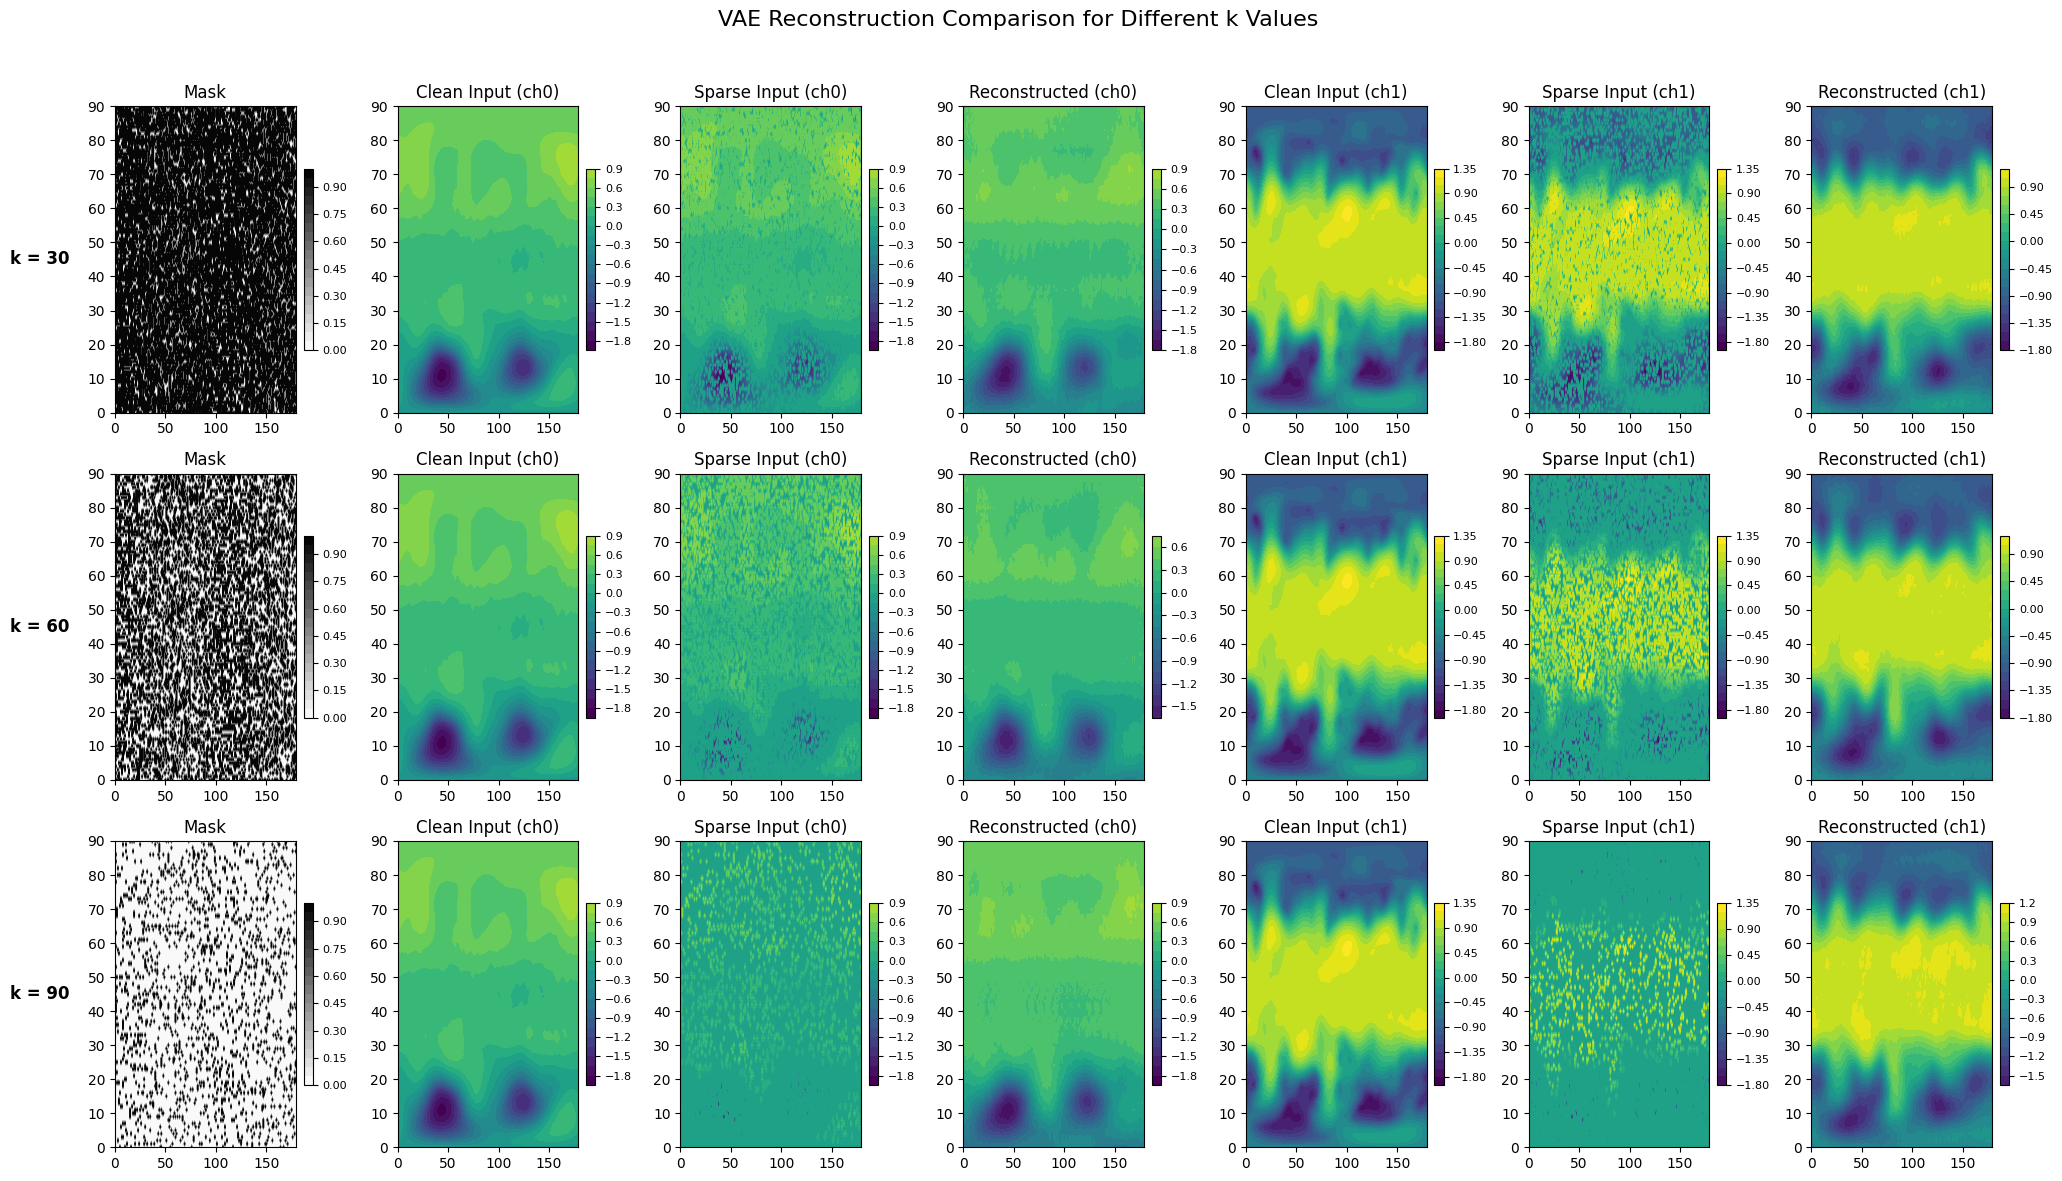

In [38]:
def visualize_all_models(models, sparse_data_list, clean_data_list, k_values=[30, 60, 90], num_samples=1):
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import torch
    
    # Validate inputs
    assert len(models) == len(sparse_data_list) == len(clean_data_list) == len(k_values), \
        "Number of models, datasets, and k values must match"
    
    # Set up the figure - 3 rows (one for each k value) with 7 columns
    fig, all_axs = plt.subplots(len(models), 7, figsize=(21, 4 * len(models)))
    
    # Add a title to the figure
    fig.suptitle('VAE Reconstruction Comparison for Different k Values', fontsize=16)
    
    # Column titles (only need to specify once)
    column_titles = [
        "Mask", 
        "Clean Input (ch0)", "Sparse Input (ch0)", "Reconstructed (ch0)",
        "Clean Input (ch1)", "Sparse Input (ch1)", "Reconstructed (ch1)"
    ]
    
    # Function to add colorbar
    def add_colorbar(c, ax):
        cbar = fig.colorbar(c, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
    
    contour_levels = 20
    
    # Process each model with its corresponding dataset
    for model_idx, (model, sparse_data, clean_data, k_value) in enumerate(
            zip(models, sparse_data_list, clean_data_list, k_values)):
        
        # Handle the case where there's only one model
        axs = all_axs[model_idx] if len(models) > 1 else all_axs
        
        # Set row title
        axs[0].annotate(f'k = {k_value}', xy=(0, 0.5), xytext=(-axs[0].yaxis.labelpad - 5, 0),
                         xycoords=axs[0].yaxis.label, textcoords='offset points',
                         size='large', ha='right', va='center', fontweight='bold')
        
        model.eval()
        with torch.no_grad():
            # Select a subset of the data for visualization
            x_sparse = sparse_data[:num_samples]
            x_clean = clean_data[:num_samples]
            
            # Generate reconstructions from sparse data
            recon_batch, _, _ = model(x_sparse)
            
            # Determine the colorbar limits based on the clean data and reconstruction
            # Only consider the data channels (first two channels)
            vmin = min(
                x_clean[:, :2].min().item(), 
                x_sparse[:, :2].min().item(),
                recon_batch[:, :2].min().item()
            )
            vmax = max(
                x_clean[:, :2].max().item(), 
                x_sparse[:, :2].min().item(),
                recon_batch[:, :2].max().item()
            )
            norm = colors.Normalize(vmin=vmin, vmax=vmax)
            
            # Only visualizing the first sample for each model to keep it clean
            i = 0  # First sample index
            
            # Plot mask first
            c = axs[0].contourf(x_sparse[i, 2].cpu(), levels=contour_levels, cmap='binary')
            axs[0].set_title(column_titles[0])
            add_colorbar(c, axs[0])
            
            # Channel 0 plots
            # Clean input (channel 0)
            c = axs[1].contourf(x_clean[i, 0].cpu(), levels=contour_levels, cmap='viridis', norm=norm)
            axs[1].set_title(column_titles[1])
            add_colorbar(c, axs[1])
            
            # Sparse input (channel 0)
            c = axs[2].contourf(x_sparse[i, 0].cpu(), levels=contour_levels, cmap='viridis', norm=norm)
            axs[2].set_title(column_titles[2])
            add_colorbar(c, axs[2])
            
            # Reconstructed input (channel 0)
            c = axs[3].contourf(recon_batch[i, 0].cpu(), levels=contour_levels, cmap='viridis', norm=norm)
            axs[3].set_title(column_titles[3])
            add_colorbar(c, axs[3])
            
            # Channel 1 plots
            # Clean input (channel 1)
            c = axs[4].contourf(x_clean[i, 1].cpu(), levels=contour_levels, cmap='viridis', norm=norm)
            axs[4].set_title(column_titles[4])
            add_colorbar(c, axs[4])
            
            # Sparse input (channel 1)
            c = axs[5].contourf(x_sparse[i, 1].cpu(), levels=contour_levels, cmap='viridis', norm=norm)
            axs[5].set_title(column_titles[5])
            add_colorbar(c, axs[5])
            
            # Reconstructed input (channel 1)
            c = axs[6].contourf(recon_batch[i, 1].cpu(), levels=contour_levels, cmap='viridis', norm=norm)
            axs[6].set_title(column_titles[6])
            add_colorbar(c, axs[6])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.subplots_adjust(left=0.07)  # Make space for row labels
    plt.show()

# Example usage:
visualize_all_models(
    [model_30, model_60, model_90],
    [sparse_data_30, sparse_data_60, sparse_data_90],
    [clean_data_30, clean_data_60, clean_data_90]
)

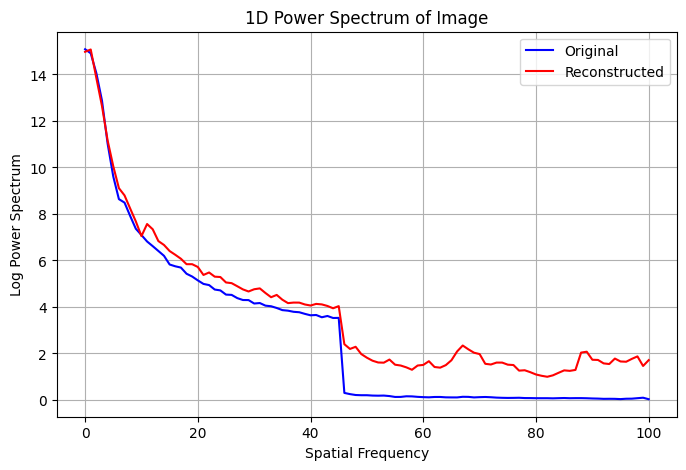

In [43]:
# Plot frequency spectrum of original and reconstructed image
def radial_profile(data):
    """ Compute the radial average of a 2D power spectrum """
    y, x = np.indices(data.shape)
    center = (x.max() / 2, y.max() / 2)
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    radial_sum = np.bincount(r.ravel(), weights=data.ravel())
    radial_count = np.bincount(r.ravel())
    radial_avg = radial_sum / (radial_count + 1e-8)  # Avoid division by zero

    return radial_avg

def plot_frequency_spectrum(original, reconstructed, time_point):
  F_original = np.fft.fft2(original[time_point, 0, :, :])
  F_reconstructed = np.fft.fft2(reconstructed[time_point, 0, :, :])

  magnitude_F_original = np.abs(np.fft.fftshift(F_original))
  magnitude_F_reconstructed = np.abs(np.fft.fftshift(F_reconstructed))

  power_spectrum_original = np.abs(magnitude_F_original ** 2)
  power_spectrum_reconstructed = np.abs(magnitude_F_reconstructed ** 2)

  radial_avg_original = radial_profile(power_spectrum_original)
  radial_avg_reconstructed = radial_profile(power_spectrum_reconstructed)

  freq = np.arange(len(radial_avg_original))
  
  # Plot the 1D power spectrum
  plt.figure(figsize=(8, 5))
  plt.plot(freq, np.log1p(radial_avg_original), label='Original', color='b')
  plt.plot(freq, np.log1p(radial_avg_reconstructed), label='Reconstructed', color='r')
  plt.xlabel('Spatial Frequency')
  plt.ylabel('Log Power Spectrum')
  plt.title('1D Power Spectrum of Image')
  plt.legend()
  plt.grid()
  plt.show()

recon_batch_30, _, _ = model_30(sparse_data_30)
recon_batch_30 = recon_batch_30.detach().numpy()
plot_frequency_spectrum(clean_data_30, recon_batch_30, 0)